# Assignment 1: Face Recognition

We intend to perform face recognition. Face recognition means that for a given image you can tell the subject id. Our database of subject is very simple. It has 40 subjects. Below we will show the needed steps to achieve the goal of the assignment.

# Code

## Imports

In [57]:
import numpy as np
import re
from matplotlib import pyplot as plt
import os
from numpy import linalg
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

# print images/plots in the notebook itself
%matplotlib inline

## helper methods

In [58]:
# We didn't use this function
def normalize (X , low , high , dtype = None ):
    X = np . asarray (X)
    minX , maxX = np . min (X ) , np . max (X)
    # normalize to [0...1].
    X = X - float ( minX )
    X = X / float (( maxX - minX ) )
    # scale to [ low ... high ].
    X = X * ( high - low )
    X = X + low
    if dtype is None :
        return np . asarray (X)
    return np . asarray (X , dtype = dtype )

In [59]:
# plots 12 images (3 x 4)
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [60]:
# imports a pgm image into a matrix
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


In [162]:
# method to find the most common label when calculating the K nearest neighbors
def most_common(lst):
    if (len(lst) == 1):
        return train_labels[lst[0]]
    frequency = [0 for i in range(41)]
    for item in lst:
        label = train_labels[item]
        frequency[label] += 1
    if max(frequency) == 1:
        return train_labels[lst[0]]
    else:
        return frequency.index(max(frequency))#,frequency


In [62]:
# finds all the class labels that has the maximum frequency in KNN (example: 3, 4, 2, 4, 3) returns -> (3, 4)
def max_class_labels(frequencies, max_freq):
    result = []
    for i in range(len(frequencies)):
        if frequencies[i] == max_freq:
            result.append(i)
    return result

In [63]:
# from all the labels that has same max frequency, returns the one with the smallest total distance.
def best_match(max_class_labels, distances, indices,train_labels):
    total_class_dist = {}
    for label in max_class_labels:
        total_class_dist[label] = 0
    for i in indices:
        if train_labels[i] in total_class_dist:
            total_class_dist[train_labels[i]] += distances[i]
    return min(total_class_dist, key=total_class_dist.get)

In [64]:
# finds the nearest neighbor after tie breaking
def nearest(distances, indices):
    label, freq = most_common(indices)
    max_freq = max(freq)
    count = freq.count(max_freq)
    if count == 1:
        return label
    else: # tie breaking
        max_class_labels = max_class_labels(freq, max_freq)
        return best_match(max_class_labels,distances,indices)

## viewing a sample image

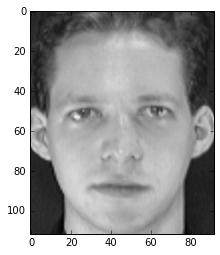

In [66]:
image = read_pgm('orl_faces/s1/1.pgm')
plt.imshow(image, plt.cm.gray)
plt.show()

In [67]:
img_vec = np.hstack(image)

In [68]:
print len(img_vec)

10304


## Create the data matrix and labels vector

In [69]:
# the images matrix that we will build
# we create a python list and later 
# convert it to a numpy matrix because
# it is faster this way.
images = []
labels = []

In [ ]:
dirnames = os.listdir('orl_faces')
dirnames.remove('README')

# sort directories by number to get the labels vector correct
dirnames.sort(key=lambda f: int(filter(str.isdigit, f)))

idx = 1
# for each folder (person), read his 10 images
for person_dir in dirnames:
    person_dir = os.path.join('orl_faces', person_dir)
    for img_file in os.listdir(person_dir):
        img = read_pgm(os.path.join(person_dir, img_file))
        print os.path.join(person_dir, img_file)
        img_vec = np.hstack(img)
        images.append(img_vec)
        labels.append(idx)
    idx += 1


In [132]:
images = np.array(images)
print images.shape

(400L, 10304L)


## Split the dataset into training and test sets

In [133]:
train_data = images[0::2]
test_data = images[1::2]
train_labels = labels[0::2]
test_labels = labels[1::2]

In [ ]:
person_titles = ["person %d" % i for i in range(1, train_data.shape[0] + 1)]
for i in range(16):
    plot_gallery(train_data[i*12:(i+1)*12], person_titles,112, 92)
    plt.show()

In [178]:
# view the test data
# person_titles = ["person %d" % i for i in range(1, test_data.shape[0] + 1)]
# for i in range(16):
#     plot_gallery(test_data[i*12:(i+1)*12], person_titles,112, 92)
#     plt.show()

## Computing PCA

### Mean and data centering

In [137]:
def center_data(train_data):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean
    return mean, centered_data

In [138]:
mean, images_centered = center_data(train_data)

### Covariance Matrix

In [140]:
covariance = (images_centered.T.dot(images_centered))/len(train_data)

In [141]:
print covariance.shape

(10304L, 10304L)


### eigenvalues and eigenvectors

In [142]:
pca_evalues, pca_evectors = linalg.eigh(covariance)

In [143]:
# sort eigenvectors according to eigenvalues
idx = pca_evalues.argsort()[::-1]
pca_evalues = pca_evalues[idx]
pca_evectors = pca_evectors[:,idx]

## Projecting the data onto the new subspace

In [84]:
# returns the number of eigenvectors needed for the explained variance = alpha
def vec_count_for_variance(evalues, alpha):
    total = sum(evalues)
    current_sum = 0.0
    idx = 0
    while current_sum/total < alpha:
        current_sum += evalues[idx]
        idx += 1
    return idx

In [85]:
# projects the train_data and test_data using the given projection matrix
def project(prj_mat, train_data, test_data):
    prj_mat = prj_mat.T

    prj_train = np.dot(train_data, prj_mat)
    prj_test = np.dot(test_data, prj_mat)
    return prj_train, prj_test

### Testing for all combinations of alpha (exp. variance) and K (neasest neighbors)

In [166]:
alphas = [0.80, 0.85, 0.90, 0.95]
Ks = [1,3,5,7]

In [167]:
def my_pca(evectors, evalues, train_data, test_data, K, alpha):
    vec_count = vec_count_for_variance(evalues, alpha)
    prj_mat = np.vstack(evectors.T[0:vec_count])
    prj_train, prj_test = project(prj_mat, train_data, test_data)
    nbrs = NearestNeighbors(n_neighbors=K).fit(prj_train)
    distances, indices = nbrs.kneighbors(prj_test)

    correct = 0
    for i in range(len(indices)):
        # print train_labels[indices[i][0]], test_labels[i]
        if most_common(indices[i]) == test_labels[i]:
            correct = correct + 1
    accuracy = 100*(correct/float(200))
    print "for alpha = {}, K = {}, accuracy is: {}".format(alpha, K, accuracy)
    return accuracy

In [168]:
accuracies = []
for alpha in alphas:
    k_accuracy = []
    for K in Ks:
        k_accuracy.append(my_pca(pca_evectors, pca_evalues, train_data, test_data, K, alpha))
    accuracies.append(k_accuracy)

for alpha = 0.8, K = 1, accuracy is: 94.0
for alpha = 0.8, K = 3, accuracy is: 89.0
for alpha = 0.8, K = 5, accuracy is: 81.0
for alpha = 0.8, K = 7, accuracy is: 76.5
for alpha = 0.85, K = 1, accuracy is: 94.0
for alpha = 0.85, K = 3, accuracy is: 88.5
for alpha = 0.85, K = 5, accuracy is: 80.0
for alpha = 0.85, K = 7, accuracy is: 73.5
for alpha = 0.9, K = 1, accuracy is: 94.0
for alpha = 0.9, K = 3, accuracy is: 89.0
for alpha = 0.9, K = 5, accuracy is: 79.0
for alpha = 0.9, K = 7, accuracy is: 72.5
for alpha = 0.95, K = 1, accuracy is: 93.0
for alpha = 0.95, K = 3, accuracy is: 88.0
for alpha = 0.95, K = 5, accuracy is: 78.0
for alpha = 0.95, K = 7, accuracy is: 70.0


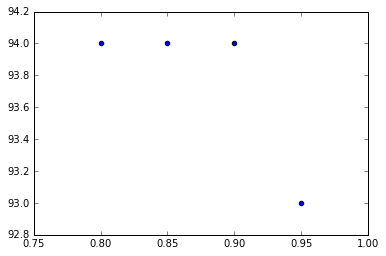

In [91]:
# plot accuracies for different alphas and K = 1
col = [row[0] for row in accuracies]
accuracy_plot = plt.figure()
ax = accuracy_plot.add_subplot(111)
ax.scatter(alphas, col, marker='o')

In [92]:
%matplotlib qt
import matplotlib.cm as cm
# plotting the data projected on 3 dimensions in 3D space
prj_3d = np.vstack(pca_evectors.T[0:3])
prj_data_3d = np.dot(train_data, prj_3d.T)
colors = cm.rainbow(np.linspace(0, 1, 200))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(prj_data_3d[:,0], prj_data_3d[:,1], prj_data_3d[:,2], c=colors)

# LDA

## Means and centering data

In [93]:
# reduce the dimensionality of the data first to
# atleast N-C = 200-40 = 160 Dimensions using PCA
# then perform LDA
lda_pca_prj = np.vstack(pca_evectors.T[0:160])
print lda_pca_prj.shape
lda_prj_train_data = np.dot(train_data, lda_pca_prj.T)
lda_prj_test_data = np.dot(test_data, lda_pca_prj.T)
print lda_prj_train_data.shape

(160L, 10304L)
(200L, 160L)


In [94]:
class_means = []

for i in range(40):
    mean_i = np.mean(lda_prj_train_data[i * 5 : (i + 1) * 5], axis = 0)
    class_means.append(mean_i)

In [95]:
class_means = np.array(class_means)
print class_means.shape

(40L, 160L)


In [96]:
centered_classes_data = np.zeros([200, 160])

In [97]:
for i in range(40):
    for j in range(5):
        centered_classes_data[i*5 + j] = lda_prj_train_data[i*5 + j] - class_means[i]

In [98]:
train_mean = np.mean(lda_prj_train_data, axis = 0)
train_mean = train_mean.reshape(1, 160)

print train_mean.shape

(1L, 160L)


## B matrix

In [99]:
B_total = np.zeros([160, 160])

In [100]:
for i in range(40):
    # Nk * (Uk - U)(Uk - U)T
    u = class_means[i] - train_mean
    B_total += 5*u.dot(u.T)


In [101]:
print B_total

[[  2.01799366e+09   2.01799366e+09   2.01799366e+09 ...,   2.01799366e+09
    2.01799366e+09   2.01799366e+09]
 [  2.01799366e+09   2.01799366e+09   2.01799366e+09 ...,   2.01799366e+09
    2.01799366e+09   2.01799366e+09]
 [  2.01799366e+09   2.01799366e+09   2.01799366e+09 ...,   2.01799366e+09
    2.01799366e+09   2.01799366e+09]
 ..., 
 [  2.01799366e+09   2.01799366e+09   2.01799366e+09 ...,   2.01799366e+09
    2.01799366e+09   2.01799366e+09]
 [  2.01799366e+09   2.01799366e+09   2.01799366e+09 ...,   2.01799366e+09
    2.01799366e+09   2.01799366e+09]
 [  2.01799366e+09   2.01799366e+09   2.01799366e+09 ...,   2.01799366e+09
    2.01799366e+09   2.01799366e+09]]


In [102]:
print B_total.shape


(160L, 160L)


In [103]:
S_total = np.zeros([160, 160])

In [104]:
for i in range(40): 
    for j in range(5):
         S_total += centered_classes_data[i*5 + j].T.dot(centered_classes_data[i*5 + j])

In [105]:
S_inv = linalg.pinv(S_total)

In [106]:
# use eig()?
lda_evalues, lda_evectors = linalg.eig(S_inv.dot(B_total))

In [107]:
print S_inv.shape

(160L, 160L)


In [108]:
idx_lda = lda_evalues.argsort()[::-1]
lda_evalues = lda_evalues[idx_lda]
lda_evectors = lda_evectors[:,idx_lda]
lda_evectors = np.real(lda_evectors)

### Projection Matrix

In [109]:
lda_prj_mat = np.vstack(lda_evectors[0:39])

In [110]:
lda_prj_mat = lda_prj_mat
print lda_prj_mat.shape
lda_prj_train = np.dot(lda_prj_train_data, lda_prj_mat.T)
lda_prj_test = np.dot(lda_prj_test_data, lda_prj_mat.T)
print lda_prj_train.shape

(39L, 160L)
(200L, 39L)


In [111]:
cascade = lda_pca_prj.transpose().dot(lda_prj_mat.transpose())
print cascade.shape

(10304L, 39L)


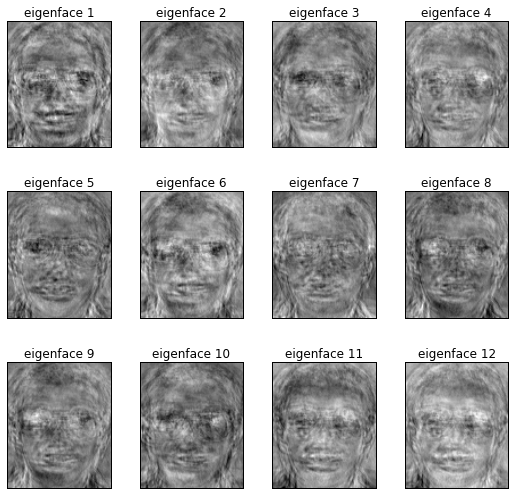

In [177]:
%matplotlib inline

person_titles = ["eigenface %d" % i for i in range(1, 40)]
plot_gallery(cascade.T, person_titles,112, 92)
plt.show()

### Nearest Neighbors Classification

In [113]:
lda_nbrs = NearestNeighbors(n_neighbors=1).fit(lda_prj_train)

In [114]:
print lda_prj_train.shape

(200L, 39L)


In [115]:
lda_distances, lda_indices = lda_nbrs.kneighbors(lda_prj_test)

### Counting correct classificaitons (accuracy)

In [129]:
lda_correct = 0
for i in range(len(lda_indices)):
    if most_common(lda_indices[i]) == test_labels[i]:
        lda_correct = lda_correct + 1
    else:
        print "classifier error:"
#         plt.imshow(train_data[most_common(lda_indices[i])].reshape(112, 92), plt.cm.gray)
#         plt.show()
#         plt.imshow(test_data[i].reshape(112, 92), plt.cm.gray)
#         plt.show()
print 100*(lda_correct/float(200))

classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
classifier error:
74.0
